# SMS Spam Classification

In this practical exercise, we will be exploring the application of the transformers library developed by Hugging Face. Our main objective is to fine-tune a BERT model specifically for the task of spam text classification. The dataset we'll be working with consists of Short Message Service (SMS) texts, and our goal is to determine whether each message is spam or not.

Throughout the hands-on, we'll go through the following steps:

1. Utilizing the transformers library from Hugging Face, we'll fine-tune a BERT model for spam text classification.
2. We'll evaluate the performance of our BERT model.

## Importing Needed Packages

### Prerequisite Libraries:

1. **re**: For regular expression processing

2. **matplotlib** and **seaborn**: For data visualization library in Python. For creating various types of plots, such as line plots, bar plots, scatter plots, etc.

3. **nltk**: Used for natural language processing (NLP) tasks in Python. It provides tools and resources for tasks like tokenization, stemming, part-of-speech tagging, and more.

4. **numpy**: Fundamental library for numerical computing in Python.

5. **pandas**:For data manipulation and analysis in Python.

7. **tensorflow**: TensorFlow is an open-source machine learning library developed by Google. It offers various tools for building and training machine learning models, especially neural networks.

8. **sklearn**: Popular machine learning library in Python. It provides a wide range of tools for tasks like data preprocessing, model selection, evaluation, and more.

14. **transformers**:  Hugging Face transformers library, which is used for working with pre-trained transformer-based models, such as BERT.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
!pip install -q transformers

In [ ]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

Next, let's install the needed corpora and pretrained model from nltk:
* punkt: Punkt Tokenizer Models.
* stopwords: Stopwords Corpus.
* wordnet: WordNet-InfoContent.

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dataset Loading

The selected dataset for this Notebook is the **SMS Spam Collection Dataset**. The decision to use this dataset is based on two reasons.
- First, the dataset offers a substantial amount of data, providing a rich resource for training machine learning models effectively.
- Second, the dataset's straightforward columns are well-suited for the purpose of comparing various machine learning algorithms.


Let's start by downlaoding and loading the dataset:

In [ ]:
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
!unzip sms+spam+collection.zip

--2023-07-30 18:01:13--  https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sms+spam+collection.zip’

sms+spam+collection     [ <=>                ] 198.65K  --.-KB/s    in 0.08s   

2023-07-30 18:01:13 (2.44 MB/s) - ‘sms+spam+collection.zip’ saved [203415]

Archive:  sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
data=pd.read_table("SMSSpamCollection",encoding="latin-1",names=["class","SMS"])
data.head()

,class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


As you have noticed, the class column has two labels, spam and ham, so it is binary classification case.  \\
Let's check the dimensions of the dataset:

In [ ]:
data.shape

(5572, 2)

Seems like the dataset has a decent size for fine-tuning our BERT model.

Let's find out the number of characters and words in each sentence:

In [ ]:
data["SMS"].str.len().describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: SMS, dtype: float64

In [ ]:
data["SMS"].str.split().str.len().describe()

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: SMS, dtype: float64

<Axes: >

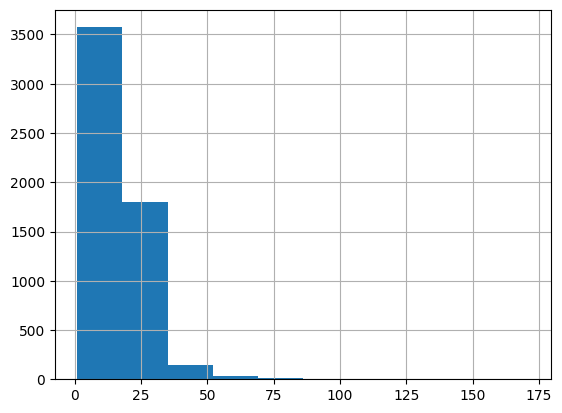

In [ ]:
data["SMS"].str.split().str.len().hist()

It seems that the sentences are made of 80 characters and 16 words on average. These insights will be useful later when preprocessing and tokenizing the sentences.

## Preprocessing

For better preprocessing for the classification algorithms, we will convert the label into a binary label:

In [ ]:
data["class"].replace({"ham": 0, "spam": 1}, inplace=True)
data.head()

,class,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Feature Enginneering
Next, we will be using the SMS text to generate new features. These new features might be later on useful for predicting the likelihood of being a spam text or not.

Here are the features we will be creating:
- **n_words**: number of words in an SMS.
- **message_len**: number of characters in an SMS.
- **n_upper_chars**: number of uppercase characters in an SMS.
- **n_upper_words**: number of uppercase words in an SMS.
- **is_free_win**: contain 1 if the SMS contains the words "free" or "win"; 0 otherwise.
- **is_url**: contain 1 if the SMS contains a URL; 0 otherwise.

In [ ]:
data["n_words"] = data["SMS"].apply(lambda s: len(re.findall(r"\w+", s)))
data["message_len"] = data["SMS"].str.len()
data["n_upper_chars"] = data["SMS"].apply(
    lambda s: sum(1 for c in s if c.isupper())
)
data["n_upper_words"] = data["SMS"].apply(
    lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s))
)
data["is_free_or_win"] = data["SMS"].apply(
    lambda s: int("free" in s.lower() or "win" in s.lower())
)
data["is_url"] = data["SMS"].str.contains(
    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
).astype(int)

data.head(n=25)

,class,SMS,n_words,message_len,n_upper_chars,n_upper_words,is_free_or_win,is_url
0,0,"Go until jurong point, crazy.. Available only ...",20,111,3,0,0,0
1,0,Ok lar... Joking wif u oni...,6,29,2,0,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,33,155,10,2,1,0
3,0,U dun say so early hor... U c already then say...,11,49,2,0,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",14,61,2,0,0,0
5,1,FreeMsg Hey there darling it's been 3 week's n...,37,148,8,0,1,0
6,0,Even my brother is not like to speak with me. ...,16,77,2,0,0,0
7,0,As per your request 'Melle Melle (Oru Minnamin...,26,160,10,0,0,0
8,1,WINNER!! As a valued network customer you have...,27,158,13,1,1,0
9,1,Had your mobile 11 months or more? U R entitle...,29,154,14,1,1,0


## Exploratory Data Analysis
Now that we generated all our new features, we can now analyze the dataset features and get a better understanding of the relationships between the different features.

First, let's check if the SMS texts are equally distributed across the two classes:

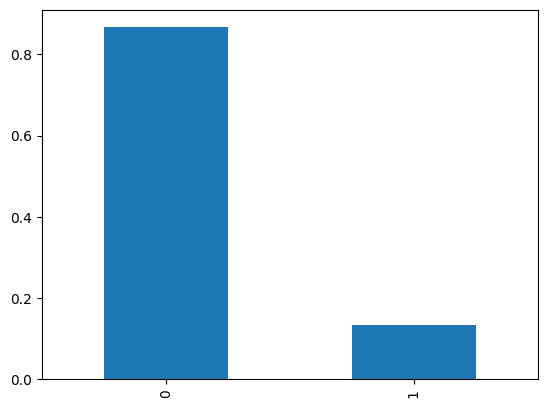

In [ ]:
data["class"].value_counts(normalize=True).plot.bar()
plt.show()

Looks like the dataset is heavily imbalanced, the majority of the messages (>80%) are ham while the minority are spam. This is important to consider later when training the models.

Next, let's investigate whether there is a possible relationship between the most frequents words and the likelihood of a message to be spam or ham. Let's plot the most frequent words across the two classes:

In [ ]:
from collections import Counter
def generate_most_freq_words(df):
  sentences_list=df["SMS"].to_list()
  joined_sentences_as_str=" ".join(sentences_list)
  words_list=joined_sentences_as_str.split()
  top_20=Counter(words_list).most_common(20)
  df=pd.DataFrame.from_dict(top_20)
  df=df.rename(columns={0: "word", 1 : "frequency"})
  return df

In [ ]:
spam_df=data[data["class"]==1].copy()
ham_df=data[data["class"]==0].copy()
top_20_spam=generate_most_freq_words(spam_df)
top_20_ham=generate_most_freq_words(ham_df)

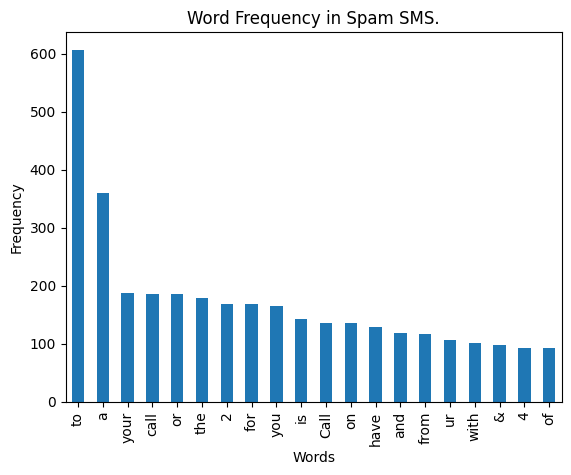

In [ ]:
top_20_spam.plot.bar(legend=False)
plt.xticks(np.arange(len(top_20_spam["word"])), top_20_spam["word"])
plt.title("Word Frequency in Spam SMS.")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

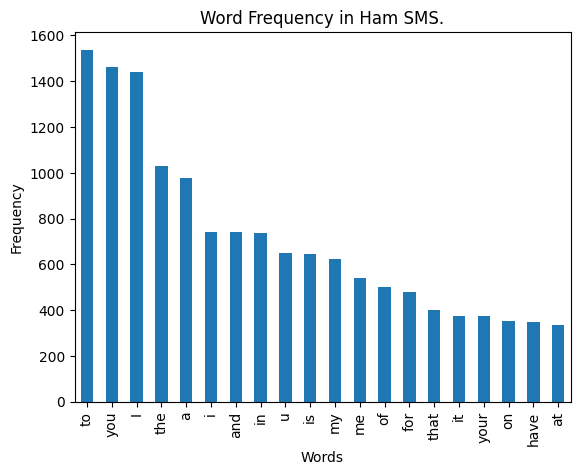

In [ ]:
top_20_ham.plot.bar(legend=False)
plt.xticks(np.arange(len(top_20_ham["word"])), top_20_ham["word"])
plt.title("Word Frequency in Ham SMS.")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

After plotting both classes, we can see that stop words are the most frequent words in both spam and ham SMS.

Next, let's investigate whether the text length has any relationship with the likelihood of a text being spam or not:  

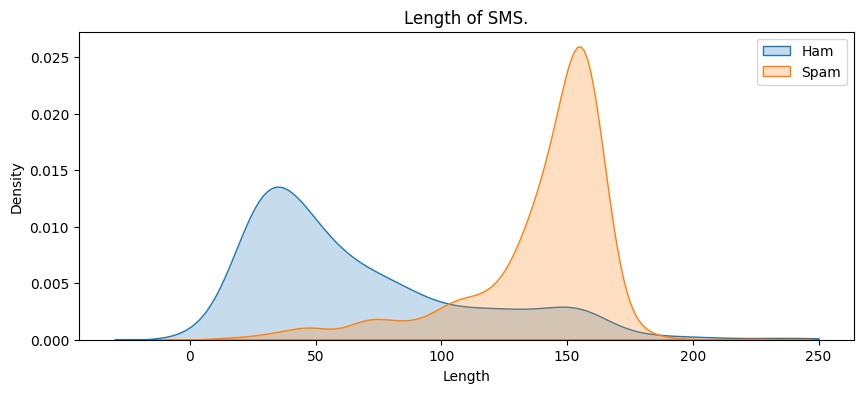

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(
    ham_df["message_len"],
    fill=True,
    label="Ham",
    clip=(-50, 250),
)
sns.kdeplot(spam_df["message_len"], fill=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of SMS.",
)
ax.legend(loc="upper right")
plt.show()


We can notice that in general, spam messages seem to be longer than ham messages with around 150 characters.


## Data Preprocessing
For preparing the text messages for model training, there exist specific important steps for preprocessing natural text:
1. Removing stop words (so,is,a)
2. Removing punctuations and digits
3. Lemmatizing the words (ex: Lemmatization[change, changing, changes] ➡️ change)

For the steps above, we will rely on the `re` library as well as specialized methods from the `nltk` library:

In [ ]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#remove punctuations
data["SMS"] = data["SMS"].str.replace(r"[^a-zA-Z]+", " ",regex=True)
#tokenize the words
data["SMS"] = data["SMS"].apply(word_tokenize)
#remove stopwords
data["SMS"] = data["SMS"].apply(
    lambda row: [
        token for token in row if token not in set(stopwords.words("english"))
    ]
)
#lemmatize
data["SMS"] = data["SMS"].apply(
    lambda row: " ".join([WordNetLemmatizer().lemmatize(word) for word in row])
)
data.head()

,class,SMS,n_words,message_len,n_upper_chars,n_upper_words,is_free_or_win,is_url
0,0,Go jurong point crazy Available bugis n great ...,20,111,3,0,0,0
1,0,Ok lar Joking wif u oni,6,29,2,0,0,0
2,1,Free entry wkly comp win FA Cup final tkts st ...,33,155,10,2,1,0
3,0,U dun say early hor U c already say,11,49,2,0,0,0
4,0,Nah I think go usf life around though,14,61,2,0,0,0


### Splitting dataset into Train and Test Sets
It is important to split the dataset into train and test sets while preserving the distribution of spam and ham texts. We will split the dataset with 80-20 split and we will make sure to follow a stratified sampling technique:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("class", axis=1), data["class"], stratify=data["class"], test_size=0.2,random_state=42
)

In [ ]:
print(f"Training data: {len(X_train)} (80%)")
print(f" Testing data: {len(X_test)} (20%)")

Training data: 4457 (80%)
 Testing data: 1115 (20%)


## Data Modelling
### Experimenting with BERT model
As previously explained in the module, BERT, or Bidirectional Encoder Representation from Transformers, is a powerful transformer model built for language modelling. We will import the BERT model from HuggingFace and fine-tune it to our use case.

### Tokenization
Tokenization will allow us to feed batches of sequences at the same time:
- SMS need to be padded to the same length
- SMS need to be truncated to match the model's maximum input length.

To perform the tokenization of the data, we also need to choose a pre-trained tokenizer. For our case, the basic model (bert-base-uncased) will be sufficient:

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Next, let's pad our sentences before encoding them using the BERT model. It is important to decide on a maximum sentence length for padding/truncating to.

We will start by performing one tokenization pass of the datasets to measure the maximum sentence length:

In [ ]:
max_len = 0
for row in X_train["SMS"]:
    max_len = max(max_len, len(tokenizer.encode(row)))
print(f"Max sentence length (train): {max_len}")

max_len = 0
for row in X_test["SMS"]:
    max_len = max(max_len, len(tokenizer.encode(row)))
print(f"Max sentence length (test): {max_len}")

Max sentence length (train): 93
Max sentence length (test): 93


Both train and test sets have a maximum sentence length of 93, therefore the maximum padding length is 93. We will this value to encoding our train and test data:

In [ ]:
MAX_PADDING_LENGTH=96
train_encodings = tokenizer(
    X_train["SMS"].tolist(),
    max_length=MAX_PADDING_LENGTH,
    padding="max_length",
    truncation=True,
)
test_encodings = tokenizer(
    X_test["SMS"].tolist(),
    max_length=MAX_PADDING_LENGTH,
    padding="max_length",
    truncation=True,
)

Next, let's wrap the encoding in TF Dataset:

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

Now, we are ready to train the BERT model!

### Fine-tuning BERT model
A pre-trained BERT model is best suited for multiple tasks, fine-tuning will not be possible. It will therefore be necessary to generate the BERT embeddings as features and pass them through an independent classifier  (RandomForest, Neural Network, etc...). for this example, we will be a linear layer on top of the pooled output

For training using a BERT, we need to define training arguments as follows:


Next, we can start training by using the `TFBertForSequenceClassification` model, which as previously mentioned hasa linear layer attached to the pooling layer, enabling the usage of the BERT model as a classification model:


In [ ]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,
                                     decay=0.01)

model.compile(optimizer=optimizer, loss=model.hf_compute_loss,metrics=['accuracy'])
model.fit(train_dataset.shuffle(1000).batch(16),epochs=8, batch_size=16)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tf_model.h5
All model checkpoint layers were used when 

Epoch 1/8
279/279 [==============================] - 155s 328ms/step - loss: 0.1003 - accuracy: 0.9675
Epoch 2/8
279/279 [==============================] - 94s 337ms/step - loss: 0.0334 - accuracy: 0.9917
Epoch 3/8
279/279 [==============================] - 93s 333ms/step - loss: 0.0190 - accuracy: 0.9964
Epoch 4/8
279/279 [==============================] - 92s 328ms/step - loss: 0.0118 - accuracy: 0.9984
Epoch 5/8
279/279 [==============================] - 91s 327ms/step - loss: 0.0117 - accuracy: 0.9982
Epoch 6/8
279/279 [==============================] - 91s 327ms/step - loss: 0.0099 - accuracy: 0.9987
Epoch 7/8
279/279 [==============================] - 91s 327ms/step - loss: 0.0081 - accuracy: 0.9987
Epoch 8/8
279/279 [==============================] - 91s 328ms/step - loss: 0.0071 - accuracy: 0.9991


Now that the model have been trained, let's save it:

In [ ]:
tf.keras.Model.save(model,"finetuned_bert")

Let's evaluate the performance of the BERT model:

In [ ]:
predictions=model.predict(test_encodings["input_ids"])[0]

35/35 [==============================] - 11s 213ms/step


In [ ]:
print(f"Test dataset size: {len(y_test)}")
print(f" Predictions size: {len(predictions)}")

Test dataset size: 1115
 Predictions size: 1115


To get rid of these logits, the vector of raw (non-normalized) predictions generated by the classification model should be passed to a normalization function to convert logits to probabilities.

For binary classification, we should use the sigmoid function and then the conversion of the probabilities into final predictions is done by taking the label for which the probability is highest.

With the help of the `argmax` function from numpy, we can bypass this process:

In [ ]:
predictions=np.argmax(predictions,axis=1)
predictions

array([0, 0, 0, ..., 0, 0, 0])

## Model Evaluation

Let's evaluate the model performance using a confusion matrix:

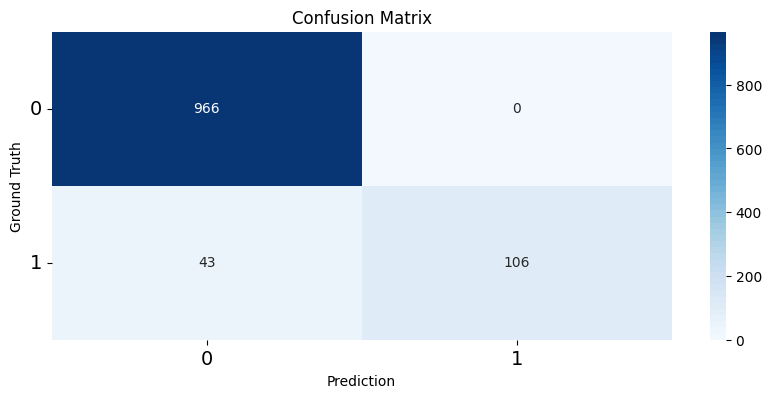

In [ ]:
plt.figure(figsize=(10, 4))

heatmap = sns.heatmap(
    data=pd.DataFrame(confusion_matrix(y_test, predictions)),
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues", 50),
)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=14)
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14
)

plt.title("Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.show()

Let's also generate a classification report:

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.71      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115



Seems like the BERT model is performing well for this task with an accuracy of 96% and a macro F1 score of 90% !